In [1]:
%matplotlib inline
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from wandb_loader import get_sweep_results, EPOCH, COCO_AP

colors = sns.color_palette("mako")

sns.set(
    style='whitegrid',
    font_scale=1.2,
    rc={
        'lines.linewidth': 1.2,
        'lines.markersize': 18,
    }
)

fig_path = Path('./imgs')

## AP vs inference time van branched models en separate model

Sweep [an4t3eqd](https://wandb.ai/jpdr/experiments/sweeps/an4t3eqd) en notebook `branched_vs_separate.ipynb`.

In [2]:
df_ap_branched = get_sweep_results("an4t3eqd", lazy=True, config_keys=['branch_layer'])

LAST_COMMON = 'Last common layer'

bl_to_last_common = {
    'layer1': 'conv1',
    'layer2': 'conv2_x',
    'layer3': 'conv3_x',
    'layer4': 'conv4_x',
    'bbox_head': 'conv5_x',
    'final_pool': 'pool',
    'roi_head': 'bbox head',
}

df_ap_branched[LAST_COMMON] = df_ap_branched['branch_layer'].apply(lambda k: bl_to_last_common[k])

order = ['None', 'conv2_x', 'conv3_x', 'conv4_x', 'conv5_x', 'bbox head']

df_ap_branched = df_ap_branched[df_ap_branched[LAST_COMMON].isin(order)]
df_ap_branched = df_ap_branched[df_ap_branched[EPOCH] == 499]

In [3]:
df_ap_sep = get_sweep_results("qn6l4ir1", lazy=True)
df_ap_sep[LAST_COMMON] = 'None'
df_ap_sep = df_ap_sep[df_ap_sep[EPOCH] == 499]

df_ap = pd.concat([df_ap_branched, df_ap_sep], ignore_index=True)

In [4]:
df_time_branched = pd.read_pickle('../02_joint_vs_separate_models/branched_models_results.pkl')
df_time_branched[LAST_COMMON] = df_time_branched['Branch layer'].apply(lambda k: bl_to_last_common[k])
df_time_branched = df_time_branched[
    (df_time_branched['Device'] == 'cpu')
    & (df_time_branched['Number of products'] == 150)
]

In [5]:
df_time_sep = pd.read_pickle('../02_joint_vs_separate_models/separate_inference_time_results.pkl')
df_time_sep = df_time_sep[df_time_sep['Device'] == 'cpu']
df_time_sep[LAST_COMMON] = 'None'
df_time_sep = df_time_sep[
    (df_time_sep['Device'] == 'cpu')
    & (df_time_sep['Number of products'] == 150)
]

df_time = pd.concat([df_time_branched, df_time_sep], ignore_index=True)

In [6]:
df = df_ap.merge(df_time, left_on=LAST_COMMON, right_on=LAST_COMMON, how='left')
df = df.groupby(LAST_COMMON).mean()

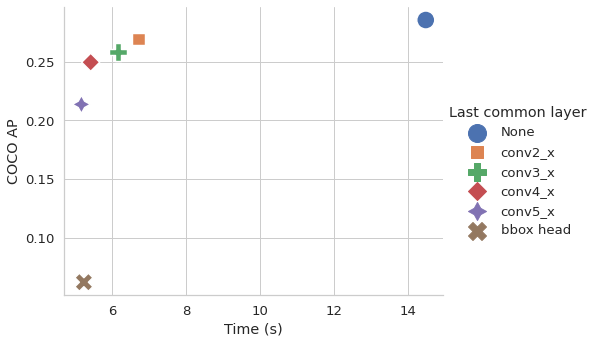

In [7]:
fig = sns.relplot(
    data=df,
    x='Time (s)',
    y=COCO_AP,
    hue=LAST_COMMON,
    style=LAST_COMMON,
    hue_order=order,
    aspect=4/3,
)

In [8]:
fig.savefig(fig_path / 'COCO_AP_vs_time.png')